### 実践演習 (85分)
#### 課題1: Chainerを用いたCNNの実装 (50分)
* MNISTデータセットを用いて、CNNの学習に挑戦
* 第6回までの知識と合わせて、正解率99%を目指そう
* 使えるツール：畳み込み層、プーリング層、Batch Normalization、SGD、Adam、Dropout

#### 課題2：Data Augmentation (20分)
* Horizontal flippingの実装 (行列のスライス)
* Scale augmentation (scipy.misc.imresize)
* Random crop/padding (np.pad)

## Colaboratory用
ランタイムをGPUにする
  - ランタイム -> ランタイムの変更
  - 「ハードウェアアクセラレータ」でGPUを選択

In [0]:
# 必要なパッケージのインストール

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip install 'chainer==4.0.0b3'

# Import
お決まりのimport

https://docs.chainer.org/en/stable/tutorial/basic.html#core-concept

In [0]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

# 課題1 Chainerを用いたCNNの実装 

MNISTデータセットを使って、CNNの学習に挑戦

### [appendix] chainer公式documentを見よう！

どんなライブラリもそうですが、公式ドキュメント・公式チュートリアルが一番充実しているのです。

3-layers MLPによるMNIST学習
https://docs.chainer.org/en/stable/tutorial/basic.html#example-multi-layer-perceptron-on-mnist

いろいろな画像認識CNNのサンプルコード
https://docs.chainer.org/en/stable/tutorial/convnet.html

## MNISTデータセット

MNISTデータセットは、かつて画像認識のベンチマークとしてよく使われた、手書き文字データセットです。

28x28ピクセル・グレースケールの0~9の数字の手書き文字画像が、学習データ60000枚、テストデータ10000枚含まれています。

### MNISTデータセットの取得

データは http://yann.lecun.com/exdb/mnist/ から取得できます。特殊なファイルフォーマット（ページ下部に記載）なので、データ読み取りプログラムを自分でちょちょっと書きますorどこかから貰ってきます。

…というのが本来なのですが、chainerが便利メソッドを用意してくれています！

In [0]:
train_and_val, test = datasets.get_mnist(ndim=3)

どんなデータなのか、少し見てみましょう

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

sample_mnist = train_and_val[0]

plt.imshow(sample_mnist[0][0], cmap='gray')
print('Label:', sample_mnist[1])

### CNNで画像分類サンプル

#### モデルの定義

In [0]:
""" このモデルは講師がテキトーに作ったモデルなので、まだまだ良くできます！
コードの書き方の参考にしつつ、もっとよいモデルを作ろう！
"""
class SampleCNN(Chain):
    def __init__(self):
        super(SampleCNN, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=20, ksize=5, stride=1, pad=0)
            self.conv2 = L.Convolution2D(in_channels=20, out_channels=50, ksize=5, stride=1, pad=0)
            self.l1 = L.Linear(None, 500)
            self.l2 = L.Linear(500, 10)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.relu(self.l1(h))
        y = F.sigmoid(self.l2(h))
        
        return y

#### 学習

In [0]:
# train_and_valをtrainとvalidationに分割
from chainer.datasets import split_dataset_random

n_train = 40000
train, validation = split_dataset_random(train_and_val, n_train, seed=42)

In [0]:
batch_size = 100
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)
validation_iter = chainer.iterators.SerialIterator(validation, batch_size=batch_size, repeat=False, shuffle=False)

In [0]:
device = 0  # GPU: 0, CPU: -1

In [0]:
net = SampleCNN()
model = L.Classifier(net)

optimizer = optimizers.Adam()
optimizer.setup(model)

updater = training.StandardUpdater(train_iter, optimizer, device=device)
trainer = training.Trainer(updater, (30, 'epoch'), out='result')

trainer.extend(extensions.Evaluator(validation_iter, model, device=device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy']))

trainer.run()

#### 評価

In [0]:
import json

with open('result/log') as f:
    logs = json.load(f)

In [0]:
loss_train = [log['main/loss'] for log in logs]
loss_validation = [log['validation/main/loss'] for log in logs]

In [0]:
plt.plot(loss_train, label='loss_train')
plt.plot(loss_validation, label='loss_validation')
plt.legend()
plt.show()

In [0]:
test_iter = chainer.iterators.SerialIterator(test, batch_size=batch_size, repeat=False, shuffle=False)

In [0]:
from chainer.dataset import concat_examples

test_accuracies = []

while True:
    test_batch = test_iter.next()
    x_test, t_test = concat_examples(test_batch, device)
    
    pred_test = net(x_test)
    accuracy = F.accuracy(pred_test, t_test)
    accuracy.to_cpu()
    test_accuracies.append(accuracy.data)
    
    if test_iter.is_new_epoch:
        test_iter.epoch = 0
        test_iter.current_position = 0
        test_iter.is_new_epoch = False
        test_iter._pushed_position = None
        break

print('Accuracy: {}'.format(np.mean(test_accuracies)))

## 課題
自分でCNNのモデルを設計し、学習してみる

### Appendix: MLP

In [0]:
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

### Appendix: LeNet5

In [0]:
class LeNet5(Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=6, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(
                in_channels=6, out_channels=16, ksize=5, stride=1)
            self.conv3 = L.Convolution2D(
                in_channels=16, out_channels=120, ksize=4, stride=1)
            self.fc4 = L.Linear(None, 84)
            self.fc5 = L.Linear(84, 10)

    def __call__(self, x):
        h = F.sigmoid(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv3(h))
        h = F.sigmoid(self.fc4(h))
        return self.fc5(h)

# 課題2 Data Augmentation
Data Augmentationを実際にやってみましょう。

numpyの行列操作やscipy, scikit-imageなどのメソッドを駆使して画像をいじります

In [6]:
!wget http://optipng.sourceforge.net/pngtech/img/lena.png -O lena_color.png

--2018-02-17 06:32:01--  http://optipng.sourceforge.net/pngtech/img/lena.png
Resolving optipng.sourceforge.net (optipng.sourceforge.net)... 216.34.181.96
Connecting to optipng.sourceforge.net (optipng.sourceforge.net)|216.34.181.96|:80... connected.
HTTP request sent, awaiting response... 503 Service Temporarily Unavailable
2018-02-17 06:32:01 ERROR 503: Service Temporarily Unavailable.



In [8]:
!wget https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/lena_color.gif -O lena_color.png

--2018-02-17 06:33:00--  https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/lena_color.gif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227335 (222K) [image/gif]
Saving to: ‘lena_color.png’

lena_color.png      100%[===================>] 222.01K  --.-KB/s    in 0.05s   

2018-02-17 06:33:01 (4.25 MB/s) - ‘lena_color.png’ saved [227335/227335]



In [0]:
import matplotlib.pyplot as plt
from skimage.io import imread

In [0]:
lena = imread('./lena_color.png')

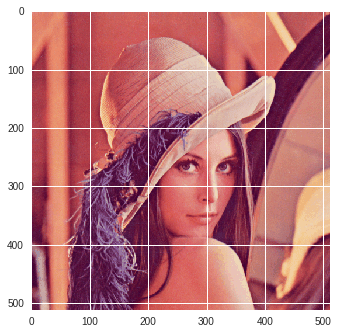

In [11]:
plt.imshow(lena)

## Horizontal flippingの実装
目標：
<img src="https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/images/lena_horizontal_flipped.png" width="200"/>

行列のスライス

ヒント(?)1
```python
x = np.array([1, 2, 3])
x[::-1]  # array([3, 2, 1])
```

ヒント(?)2
```python
x = np.array([
  [1, 2, 3],
  [4, 5, 6],
  [7, 8, 9],
])
x[:, 1]  # array([2, 5, 8])
```

## Scale augmentation
目標(例:1.2倍)：
<img src="https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/images/lena_zoom120.png" width="200"/>

scipy.misc.imresize

## Random crop
目標（例）:

<img src="https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/images/lena_cropped_0.png" width="200"/>
<img src="https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/images/lena_cropped_1.png" width="200"/>
<img src="https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/images/lena_cropped_2.png" width="200"/>
<img src="https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/images/lena_cropped_3.png" width="200"/>